# `Setup`

In [265]:
# Library Import
import pandas as pd
import numpy as np
import os
if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
from utils.helpers import * # Import all helper functions
from utils.StatefarmPytorchDataset import StateFarmDataset # Import Pytorch dataset class
from IPython.display import display, clear_output, Image as ipyImage
from PIL import Image, ImageDraw, ImageFont
import random
import time
import cv2
from tqdm import tqdm



# Printing current working directory
print(os.getcwd())

/Users/alexanderries/aml_itu


In [266]:
import matplotlib.pyplot as plt
import seaborn as sns

### `Config`

In [267]:
# Loading the config file
config = load_config()
    
    
# Training Images
train_img = config['dataset']['images']['train']

# Outputting config    
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'}}

In [268]:
# Loading the data
df = pd.read_csv(config['dataset']['data'])

In [269]:
config['dataset']['class_mapping']

{'c0': 'safe driving',
 'c1': 'texting - right',
 'c2': 'talking on the phone - right',
 'c3': 'texting - left',
 'c4': 'talking on the phone - left',
 'c5': 'operating the radio',
 'c6': 'drinking',
 'c7': 'reaching behind',
 'c8': 'hair and makeup',
 'c9': 'talking to passenger'}

In [270]:
df['target'] = df['classname'].map(config['dataset']['class_mapping'])

## Open Pose Test

inspired by: https://www.youtube.com/watch?v=9jQGsUidKHs and https://www.kaggle.com/code/ishwarbb23/openpose

In [271]:
import cv2 as cv
import matplotlib.pyplot as plt


In [272]:
# load pretrained weights from openpose
net = cv.dnn.readNetFromTensorflow('./openpose/graph_opt.pb')

In [273]:
inWidth = 368
inHeight = 368


In [282]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"]]

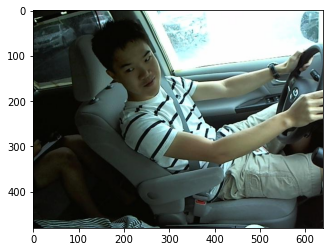

In [275]:
# load one iamge, grayscale and plot
img = cv.imread(os.path.join(train_img, df_talk.iloc[0].classname, df_talk.iloc[0].img))
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)


In [276]:
def pose_estimation(frame):
    # define inWidth and inHeight
    inWidth = 368
    inHeight = 368
    thr = 0.1
    
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]
    assert(len(BODY_PARTS) == out.shape[1])
    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)
    return points

In [277]:
# pack procedure into a function
def draw_bodypose(path):
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    points = pose_estimation(img)

    # create a blank canvas to draw on and color it white
    height, width, _ = img.shape
    blank = np.zeros((height, width, 3), np.uint8)
    blank[:] = (255, 255, 255)

    # plot only points and lines and onto the canvas
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)
        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        if points[idFrom] and points[idTo]:
            cv.line(blank, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(blank, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(blank, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    return blank
    

In [278]:
# pack procedure into a function
def detect_bodypose(path):
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    points = pose_estimation(img)

    # plot only points and lines and onto the canvas
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)
        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]
        if points[idFrom] and points[idTo]:
            cv.line(img, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(img, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(img, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    return img

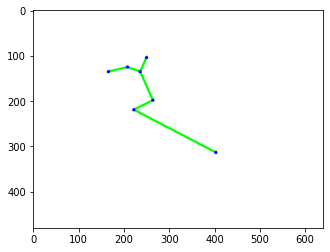

In [279]:
# test the function
img = draw_bodypose((os.path.join(train_img, df_talk.iloc[0].classname, df_talk.iloc[0].img)))

# plot the image
plt.imshow(img)

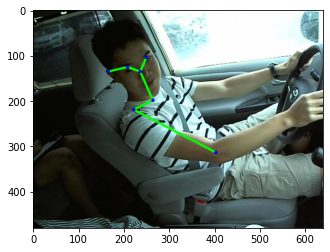

In [280]:
# test the function
img = detect_bodypose((os.path.join(train_img, df_talk.iloc[0].classname, df_talk.iloc[0].img)))

# plot the image
plt.imshow(img)

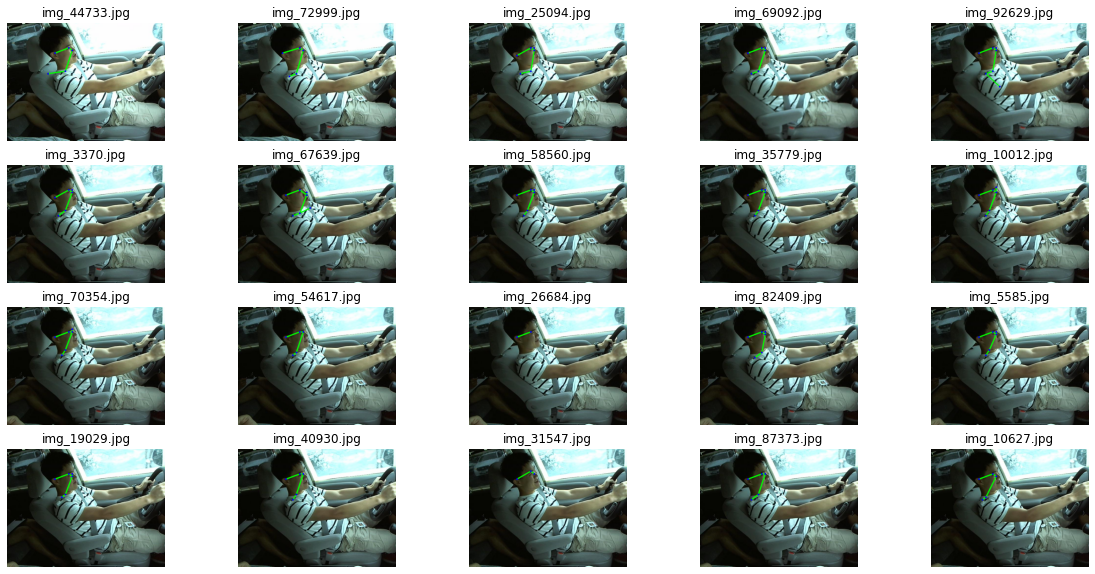

In [281]:
# filter images with target 'reach behind'
df_reach = df[df['target'] == 'safe driving']

# draw bodypose for every image and save to a list, then average over the list show progress with tqdm
img_list = []
for i in range(20):
    img = detect_bodypose((os.path.join(train_img, df_reach.iloc[i].classname, df_reach.iloc[i].img)))
    img_list.append(img)

# plot all images
fig, axes = plt.subplots(4, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_list[i])
    ax.set_title(df_reach.iloc[i].img)
    ax.axis('off')
